In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore")

file_name = 'ca2.pa.csv'
df = pd.read_csv(file_name)
print(df.head())


# Convert column names to lower case and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Drop all-NaN rows/columns
df.dropna(how='all', inplace=True)
df.dropna(axis=1, how='all', inplace=True)

# a. Handle missing values (fill with median for numerical, mode for categorical)
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col].fillna(df[col].median(), inplace=True)
    elif df[col].dtype == 'object':
        if not df[col].isnull().all():
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df.drop(col, axis=1, inplace=True) # Drop if all values are NaN

# b. Converted categorical attributes using Label Encoding
categorical_cols = ['city', 'country']
le = LabelEncoder()
for col in categorical_cols:
    if col in df.columns:
        df[col] = le.fit_transform(df[col])

# Drop 'date' column as it requires time-series specific feature engineering
if 'date' in df.columns:
    df.drop('date', axis=1, inplace=True)

# Define features (X) and target (y)
X = df.drop('o3', axis=1)
y = df['o3']

# Standardize features for better model performance (especially Linear and KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

print(f"Dataset split: Train {len(X_train)} samples, Test {len(X_test)} samples.")


# 3. Performed EDA
preprocessed_df = X_scaled_df.copy()
preprocessed_df['o3'] = y

plt.figure(figsize=(15, 12))

# a. Correlation Plot / Heatmap
plt.subplot(2, 2, 1)
corr_matrix = preprocessed_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')

# b. Distribution of Target Variable O3
plt.subplot(2, 2, 2)
sns.histplot(y, kde=True, bins=30)
plt.title('Distribution of O3 (Target Variable)')
plt.xlabel('O3 Concentration')
plt.ylabel('Frequency')

# c. Top correlated features vs O3 (Trend lines/Scatter plots)
o3_corr = corr_matrix['o3'].abs().sort_values(ascending=False).index.tolist()
top_features = [feat for feat in o3_corr if feat != 'o3'][:2] # Taking top 2 to fit in the 2x2 grid

for i, feature in enumerate(top_features):
    plt.subplot(2, 2, 3 + i)
    sns.regplot(x=preprocessed_df[feature], y=preprocessed_df['o3'], scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    plt.title(f'O3 vs {feature.upper()}')

plt.tight_layout()
plt.savefig('eda_plots.png')
plt.close()

# ==============================================================================
# 4. Implemented and compared five ML models & 5. Evaluated results
# ==============================================================================
print("\n--- Implementing and Evaluating 5 ML Models ---")

def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Trains a model and returns RMSE and R^2 score on the test set."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

results = {}

# 1. Linear Regression
lr = LinearRegression()
results['Linear Regression'] = evaluate_model(lr, X_train, y_train, X_test, y_test)

# 2. Polynomial Regression (Degree 2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
poly_lr = LinearRegression()
results['Polynomial Regression'] = evaluate_model(poly_lr, X_train_poly, y_train, X_test_poly, y_test)

# 3. KNN Regression
knn = KNeighborsRegressor(n_neighbors=5)
results['KNN Regression'] = evaluate_model(knn, X_train, y_train, X_test, y_test)

# 4. Decision Tree Regression
dt = DecisionTreeRegressor(random_state=42)
results['Decision Tree Regression'] = evaluate_model(dt, X_train, y_train, X_test, y_test)

# 5. Random Forest Regression
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
results['Random Forest Regression'] = evaluate_model(rf, X_train, y_train, X_test, y_test)

# Create a summary DataFrame
performance_df = pd.DataFrame(results, index=['RMSE', 'R² Score']).T
performance_df['RMSE'] = performance_df['RMSE'].round(4)
performance_df['R² Score'] = performance_df['R² Score'].round(4)
performance_df_sorted = performance_df.sort_values(by='R² Score', ascending=False)

# Print final comparison
print("\n--- Model Performance Comparison ---")
print(performance_df_sorted)
performance_df_sorted.to_csv('model_performance.csv')

# Generate a bar plot for visual comparison
fig, ax = plt.subplots(figsize=(10, 6))
# Plot R^2 Score on primary axis (left)
performance_df_sorted['R² Score'].plot(kind='bar', ax=ax, width=0.4, position=1, color='blue', label='R² Score')
# Plot RMSE on secondary axis (right)
ax2 = ax.twinx()
performance_df_sorted['RMSE'].plot(kind='bar', ax=ax2, width=0.4, position=0, color='red', alpha=0.6, label='RMSE')

# Set labels and title
ax.set_ylabel(r'R² Score', color='blue')
ax2.set_ylabel('RMSE', color='red')
ax.set_title('Model Performance Comparison (RMSE and R² Score)')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', linestyle='--')

# Adjust legend
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('model_comparison_plot.png')
plt.close()

--- Initial Data Inspection ---
             City   Country        Date   PM2.5    PM10    NO2    SO2    CO  \
0         Bangkok  Thailand  19-03-2023   86.57   25.19  99.88  30.63  4.46   
1        Istanbul    Turkey  16-02-2023   50.63   97.39  48.14   8.71  3.40   
2  Rio de Janeiro    Brazil  13-11-2023  130.21   57.22  98.51   9.92  0.12   
3          Mumbai     India  16-03-2023  119.70  130.52  10.96  33.03  7.74   
4           Paris    France  04-04-2023   55.20   36.62  76.85  21.85  2.00   

       O3  Temperature  Humidity  Wind Speed  
0   36.29        17.67     59.35       13.76  
1  144.16         3.46     67.51        6.36  
2  179.31        25.29     29.30       12.87  
3   38.65        23.15     99.97        7.71  
4   67.09        16.02     90.28       14.16  

--- Initial Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  

In [3]:
# Generate a bar plot for visual comparison
fig, ax = plt.subplots(figsize=(10, 6))
# Plot R^2 Score on primary axis (left)
performance_df_sorted['R² Score'].plot(kind='bar', ax=ax, width=0.4, position=1, color='blue', label='R² Score')
# Plot RMSE on secondary axis (right)
ax2 = ax.twinx()
performance_df_sorted['RMSE'].plot(kind='bar', ax=ax2, width=0.4, position=0, color='red', alpha=0.6, label='RMSE')

# Set labels and title
ax.set_ylabel(r'R² Score', color='blue')
ax2.set_ylabel('RMSE', color='red')
ax.set_title('Model Performance Comparison (RMSE and R² Score)')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', linestyle='--')

# Adjust legend
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('model_comparison_plot.png')
plt.close()

Text(0.5, 1.0, 'Correlation Heatmap')

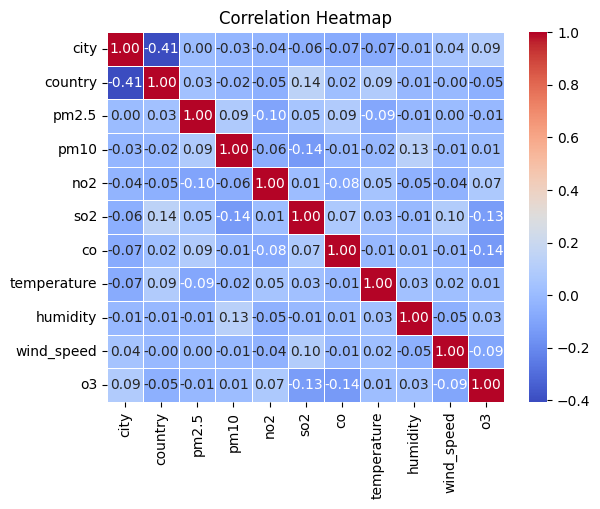

In [15]:
# a. Correlation Plot / Heatmap
#plt.subplot(1, 1, 1)
corr_matrix = preprocessed_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')



Text(0, 0.5, 'Frequency')

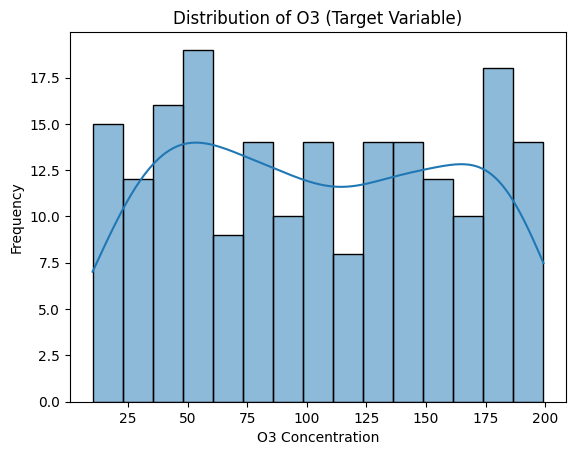

In [20]:
# b. Distribution of Target Variable O3
#plt.subplot(2, 2, 2)
sns.histplot(y, kde=True, bins=15)
plt.title('Distribution of O3 (Target Variable)')
plt.xlabel('O3 Concentration')
plt.ylabel('Frequency')

# 